In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
import numpy as np
import folium
import requests
import time
from folium.plugins import MarkerCluster

In [2]:
file_path = '2.csv'
network_data = pd.read_csv(file_path)

In [3]:
sns.set_theme(style="whitegrid")

In [4]:
def protocol_distribution(data):
    plt.figure(figsize=(10, 6))
    protocol_counts = data['Protocol'].value_counts()
    sns.barplot(x=protocol_counts.index, y=protocol_counts.values, palette="viridis")
    plt.title("Protocol Distribution")
    plt.xlabel("Protocol")
    plt.ylabel("Packet Count")
    plt.xticks(rotation=45)
    plt.show()

In [5]:
def bandwidth_usage(data):
    data['Time'] = pd.to_numeric(data['Time'], errors='coerce')
    data = data.sort_values(by="Time")
    data['Cumulative Length'] = data['Length'].cumsum() / 1e6  # Convert to MB for better readability

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=data, x="Time", y="Cumulative Length", color="purple")
    plt.title("Cumulative Bandwidth Usage Over Time")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Data Transferred (MB)")
    plt.show()

In [6]:
def detect_anomalies(data):
    data_for_model = data[['Length']]
    isolation_forest = IsolationForest(contamination=0.01, random_state=42)
    data['Anomaly'] = isolation_forest.fit_predict(data_for_model)
    anomalies = data[data['Anomaly'] == -1]

    print(f"Total anomalies detected: {len(anomalies)}")
    anomalies.to_csv("network_anomalies.csv", index=False)

    plt.figure(figsize=(14, 6))
    sns.scatterplot(data=data, x='Time', y='Length', hue='Anomaly', palette={1: 'blue', -1: 'red'}, legend="full")
    plt.title("Anomalies in Network Traffic Based on Packet Length")
    plt.xlabel("Time (s)")
    plt.ylabel("Packet Length (bytes)")
    plt.legend(["Normal", "Anomalies"])
    plt.show()

In [7]:
def source_destination_analysis(data):
    source_counts = data['Source'].value_counts().head(10)
    destination_counts = data['Destination'].value_counts().head(10)

    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    sns.barplot(x=source_counts.values, y=source_counts.index, ax=ax[0], palette="Blues")
    ax[0].set_title("Top 10 Source IPs")
    ax[0].set_xlabel("Packet Count")
    ax[0].set_ylabel("Source IP")

    sns.barplot(x=destination_counts.values, y=destination_counts.index, ax=ax[1], palette="Reds")
    ax[1].set_title("Top 10 Destination IPs")
    ax[1].set_xlabel("Packet Count")
    ax[1].set_ylabel("Destination IP")

    plt.tight_layout()
    plt.show()

In [8]:
def network_latency_analysis(data):
    data['Time'] = pd.to_numeric(data['Time'], errors='coerce')
    response_times = []
    grouped = data.groupby(['Source', 'Destination', 'Protocol'])

    for (src, dest, proto), group in grouped:
        group = group.sort_values('Time')
        if len(group) > 1:
            time_diffs = group['Time'].diff().dropna()
            avg_latency = time_diffs.mean()
            response_times.append({'Source': src, 'Destination': dest, 'Protocol': proto, 'Avg_Latency': avg_latency})

    latency_df = pd.DataFrame(response_times)
    latency_df = latency_df.sort_values(by='Avg_Latency', ascending=False).head(10)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Avg_Latency', y='Destination', hue='Protocol', data=latency_df)
    plt.title("Top 10 Latencies by Destination and Protocol")
    plt.xlabel("Average Latency (s)")
    plt.ylabel("Destination IP")
    plt.legend(title="Protocol")
    plt.show()


In [9]:
def network_health_dashboard(data):
    packet_loss_rate = len(data[data['Length'] == 0]) / len(data) * 100
    jitter = data['Time'].diff().std()
    rtt_samples = data.groupby(['Source', 'Destination']).apply(lambda group: group['Time'].diff().mean()).mean()

    # create a new figure
    fig, ax = plt.subplots(1, 3, figsize=(15, 6))
    # print packet loss rate, jitter, and RTT samples in the figure
    ax[0].text(0.5, 0.5, f"Packet Loss Rate: {packet_loss_rate:.2f}%", ha='center', fontsize=14)
    ax[0].axis('off')
    ax[1].text(0.5, 0.5, f"Jitter: {jitter:.2f}", ha='center', fontsize=14)
    ax[1].axis('off')
    ax[2].text(0.5, 0.5, f"RTT Samples: {rtt_samples:.2f}", ha='center', fontsize=14)
    ax[2].axis('off')
    plt.show()
    

In [10]:
def Connection_Duration_Analysis(data):
    data['Time'] = pd.to_numeric(data['Time'], errors='coerce')
    connection_durations = []
    grouped = data.groupby(['Source', 'Destination', 'Protocol'])

    for (src, dest, proto), group in grouped:
        group = group.sort_values('Time')
        if len(group) > 1:
            duration = group['Time'].max() - group['Time'].min()
            connection_durations.append({'Source': src, 'Destination': dest, 'Protocol': proto, 'Duration': duration})
        
    duration_df = pd.DataFrame(connection_durations)
    duration_df = duration_df.sort_values(by='Duration', ascending=False).head(10)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Duration', y='Destination', hue='Protocol', data=duration_df, palette="muted")
    plt.title("Top 10 Connection Durations by Destination and Protocol")
    plt.xlabel("Duration (s)")
    plt.ylabel("Destination IP")
    plt.legend(title="Protocol")
    plt.show()

In [11]:
suspicious_keywords = ['DHCP', 'LLMNR', 'Transaction ID', 'query']

def detailed_packet_inspection_alert(data, keywords):
    alerts = []
    for index, row in data.iterrows():
        info = str(row['Info'])  # Ensure 'Info' is treated as a string
        if any(keyword in info for keyword in keywords):
            alert = {
                'Packet No': row['No.'],
                'Time': row['Time'],
                'Source': row['Source'],
                'Destination': row['Destination'],
                'Protocol': row['Protocol'],
                'Length': row['Length'],
                'Info': info
            }
            alerts.append(alert)
            print(f"Alert: Suspicious activity detected in packet {row['No.']}.\nDetails: {alert}\n")
    if not alerts:
        print("No suspicious activity detected based on provided keywords.")

C:\Users\kisho\AppData\Local\Temp\ipykernel_25456\409097404.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=protocol_counts.index, y=protocol_counts.values, palette="viridis")


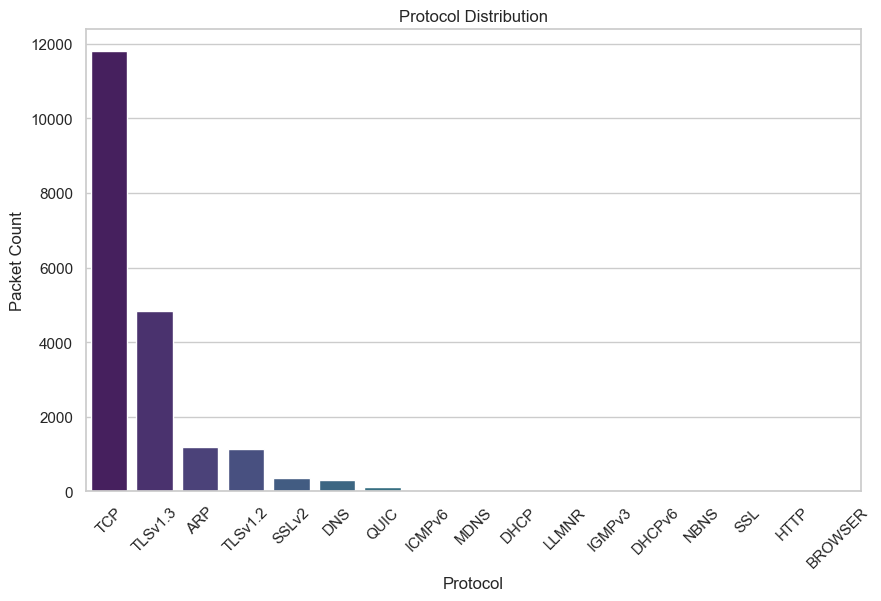

In [12]:
protocol_distribution(network_data)

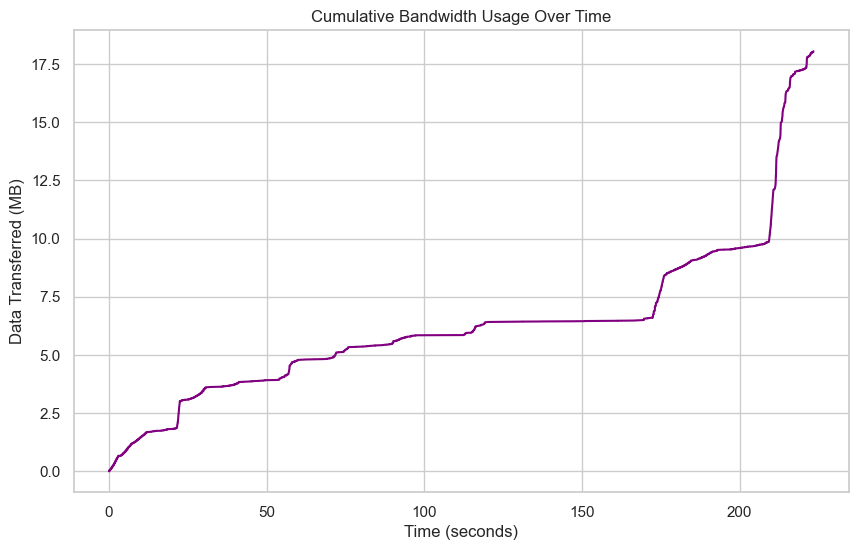

In [13]:
bandwidth_usage(network_data)

Total anomalies detected: 199


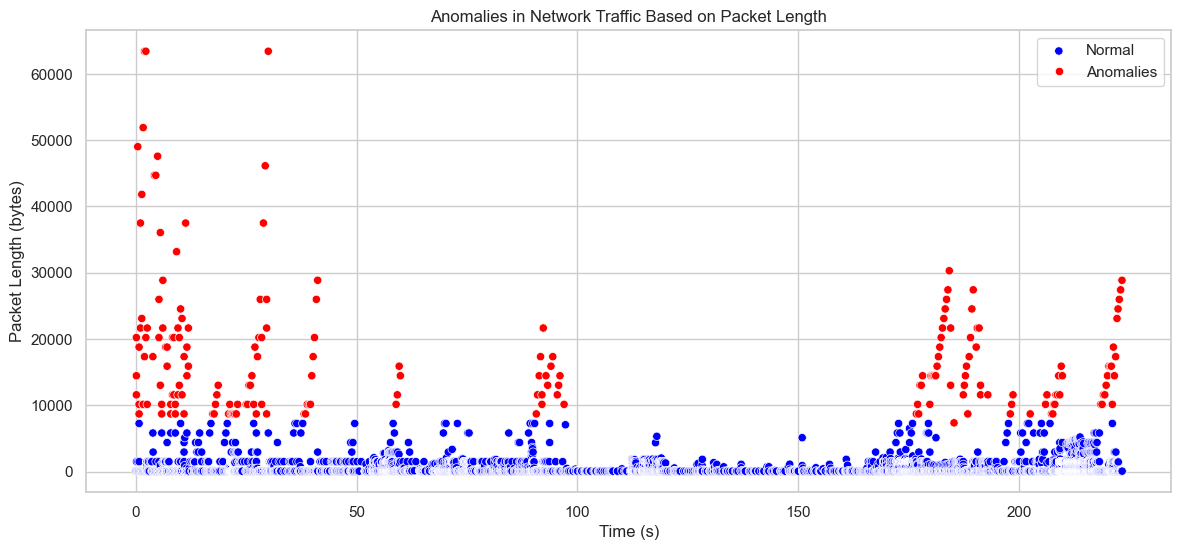

In [14]:
detect_anomalies(network_data)

C:\Users\kisho\AppData\Local\Temp\ipykernel_25456\4287593323.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=source_counts.values, y=source_counts.index, ax=ax[0], palette="Blues")
C:\Users\kisho\AppData\Local\Temp\ipykernel_25456\4287593323.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=destination_counts.values, y=destination_counts.index, ax=ax[1], palette="Reds")


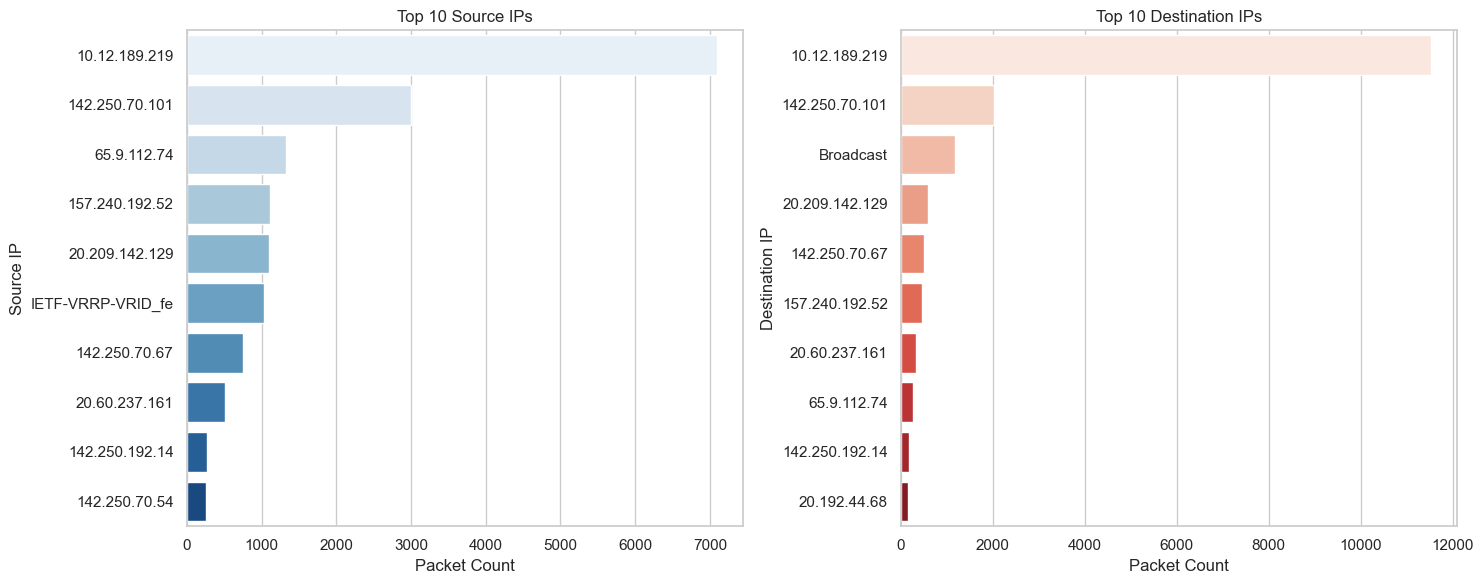

In [15]:
source_destination_analysis(network_data)

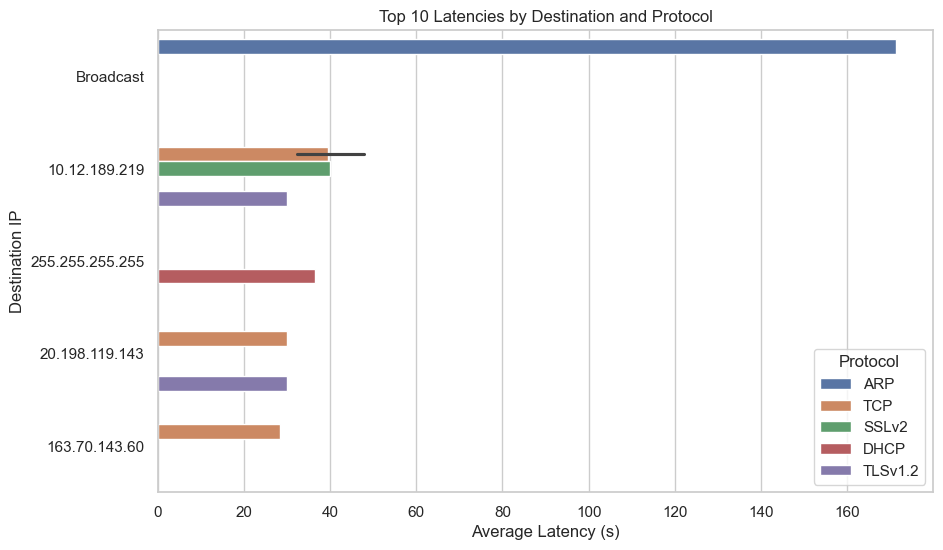

In [16]:
network_latency_analysis(network_data)

C:\Users\kisho\AppData\Local\Temp\ipykernel_25456\241376629.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rtt_samples = data.groupby(['Source', 'Destination']).apply(lambda group: group['Time'].diff().mean()).mean()


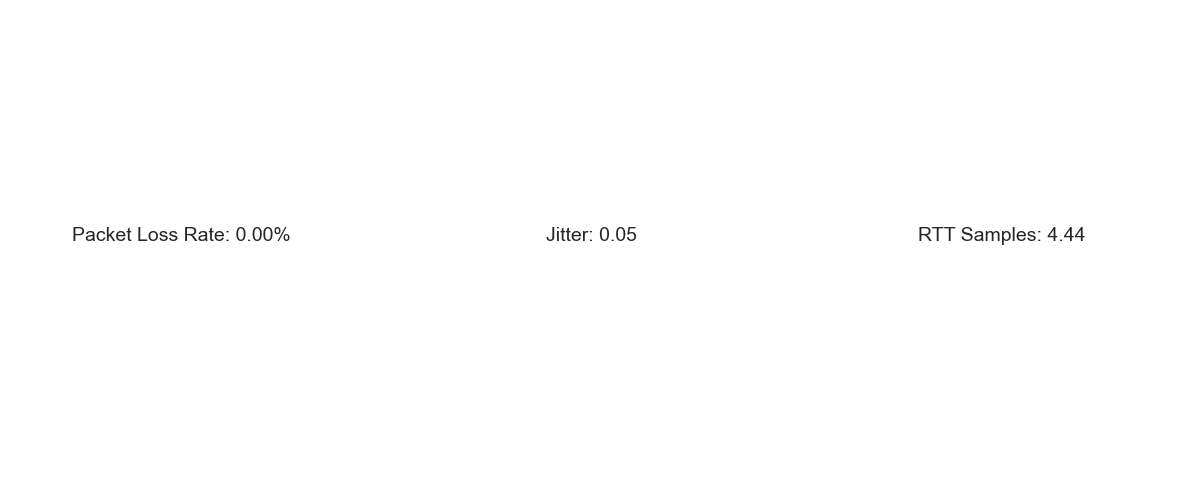

In [17]:
network_health_dashboard(network_data)

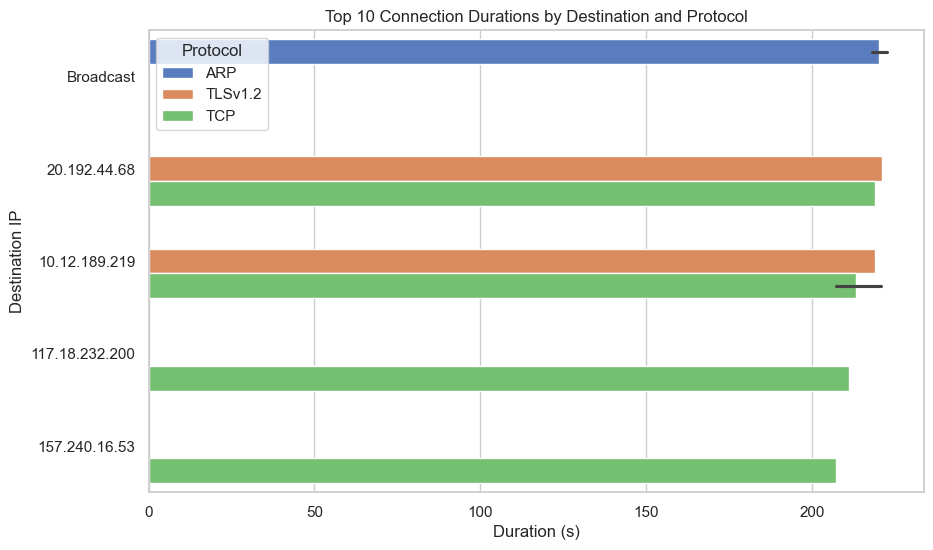

In [18]:
Connection_Duration_Analysis(network_data)

In [19]:
detailed_packet_inspection_alert(network_data, suspicious_keywords)

Alert: Suspicious activity detected in packet 2315.
Details: {'Packet No': 2315, 'Time': 25.938115, 'Source': '172.17.18.4', 'Destination': '255.255.255.255', 'Protocol': 'DHCP', 'Length': 408, 'Info': 'DHCP ACK      - Transaction ID 0xe9ff689a'}

Alert: Suspicious activity detected in packet 2325.
Details: {'Packet No': 2325, 'Time': 26.222925, 'Source': '172.17.18.4', 'Destination': '255.255.255.255', 'Protocol': 'DHCP', 'Length': 408, 'Info': 'DHCP ACK      - Transaction ID 0x4ea5394b'}

Alert: Suspicious activity detected in packet 2983.
Details: {'Packet No': 2983, 'Time': 52.869871, 'Source': '172.17.18.4', 'Destination': '255.255.255.255', 'Protocol': 'DHCP', 'Length': 408, 'Info': 'DHCP ACK      - Transaction ID 0x9c32b5e5'}

Alert: Suspicious activity detected in packet 2986.
Details: {'Packet No': 2986, 'Time': 53.521345, 'Source': '10.12.189.219', 'Destination': '172.17.18.2', 'Protocol': 'DNS', 'Length': 75, 'Info': 'Standard query 0x25e2 A www.youtube.com'}

Alert: Suspici

In [20]:
API_KEY = '89b10a8dc4074c81958855e20be25f61'
def get_geolocation(ip):
    url = f"https://api.ipgeolocation.io/ipgeo?apiKey={API_KEY}&ip={ip}"
    try:
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            lat = data.get("latitude")
            lon = data.get("longitude")
            return float(lat), float(lon)
    except Exception as e:
        print(f"Error getting location for IP {ip}: {e}")
    return None, None

ip_cache = {}
unique_ips = pd.concat([network_data['Source'], network_data['Destination']]).unique()
print(f" unique IPs location")

latitudes, longitudes = [], []
for ip in unique_ips:
    if ip in ip_cache:
        lat, lon = ip_cache[ip]
    else:
        lat, lon = get_geolocation(ip)
        ip_cache[ip] = (lat, lon)
        time.sleep(1)
    
    if lat and lon:
        latitudes.append(lat)
        longitudes.append(lon)

if latitudes and longitudes:
    avg_lat = sum(latitudes) / len(latitudes)
    avg_lon = sum(longitudes) / len(longitudes)
else:
    avg_lat, avg_lon = 0, 0

mymap = folium.Map(location=[avg_lat, avg_lon], zoom_start=2)
marker_cluster = MarkerCluster().add_to(mymap)
for ip, (lat, lon) in ip_cache.items():
    if lat and lon:
        if ip in network_data['Source'].values:
            color = "blue"
        elif ip in network_data['Destination'].values:
            color = "red"
        else:
            color = "gray"

        folium.Marker(
            [lat, lon],
            popup=f"IP: {ip}",
            icon=folium.Icon(color=color)
        ).add_to(marker_cluster)
mymap.save("network_traffic_map.html")
mymap


 unique IPs location


In [21]:
print("IP Locations:")
for ip, (lat, lon) in ip_cache.items():
    if lat and lon:
        print(f"IP: {ip} -> Latitude: {lat}, Longitude: {lon}")

IP Locations:
IP: 20.192.44.68 -> Latitude: 18.50423, Longitude: 73.85286
IP: 20.209.142.129 -> Latitude: 41.58981, Longitude: -93.61538
IP: 117.18.232.200 -> Latitude: 33.97572, Longitude: -118.4264
IP: 172.17.18.54 -> Latitude: 38.84275, Longitude: -77.43924
IP: 104.21.64.125 -> Latitude: 37.78035, Longitude: -122.39059
IP: 20.50.80.214 -> Latitude: 53.34807, Longitude: -6.24827
IP: 157.240.16.53 -> Latitude: 19.14045, Longitude: 72.88234
IP: 108.159.80.57 -> Latitude: 47.6224, Longitude: -122.33691
IP: 185.199.109.154 -> Latitude: 37.78229, Longitude: -122.39117
IP: 13.126.70.76 -> Latitude: 19.07598, Longitude: 72.87766
IP: 185.199.111.133 -> Latitude: 37.78229, Longitude: -122.39117
IP: 157.240.192.52 -> Latitude: 13.08362, Longitude: 80.28252
IP: 163.70.143.60 -> Latitude: 19.14045, Longitude: 72.88234
IP: 163.70.138.60 -> Latitude: 19.14045, Longitude: 72.88234
IP: 157.240.23.53 -> Latitude: 19.14045, Longitude: 72.88234
IP: 163.70.139.60 -> Latitude: 19.14045, Longitude: 72.882

In [ ]:
network_data['Timestamp'] = pd.to_datetime(network_data['Time'], unit='s')
network_data.set_index('Timestamp', inplace=True)
packet_rate = network_data.groupby('Source').resample('1S').size().reset_index(name='PacketCount')
average_packet_rate = packet_rate.groupby('Source')['PacketCount'].mean()
HIGH_TRAFFIC_THRESHOLD = 10
high_traffic_periods = packet_rate[packet_rate['PacketCount'] > HIGH_TRAFFIC_THRESHOLD]
print("Average Packet Rate per IP:")
print(average_packet_rate)
print("\nHigh-Traffic Periods:")
print(high_traffic_periods[['Source', 'Timestamp', 'PacketCount']])


Average Packet Rate per IP:
Source
0.0.0.0                       0.600000
10.12.189.219                31.656250
104.21.64.125                 1.043478
108.158.61.105                5.666667
108.159.61.18                 4.333333
                               ...    
HewlettPacka_81:05:00         0.575342
IETF-VRRP-VRID_fe             4.620536
Intel_25:e7:6b                0.348837
Intel_e2:a2:8e                0.058140
fe80::752e:7b30:3759:dc9e     0.871429
Name: PacketCount, Length: 93, dtype: float64

High-Traffic Periods:
                 Source           Timestamp  PacketCount
5         10.12.189.219 1970-01-01 00:00:00           13
7         10.12.189.219 1970-01-01 00:00:02           78
10        10.12.189.219 1970-01-01 00:00:05           15
11        10.12.189.219 1970-01-01 00:00:06           59
12        10.12.189.219 1970-01-01 00:00:07           27
...                 ...                 ...          ...
5251        65.9.112.84 1970-01-01 00:01:12           26
5255      8

C:\Users\kisho\AppData\Local\Temp\ipykernel_25456\1839222679.py:3: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  packet_rate = network_data.groupby('Source').resample('1S').size().reset_index(name='PacketCount')


: 